In [1]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=120.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=120.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [2]:
using Random
using Statistics
using Revise
using GaussianProcesses

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/alternative_depots/climate/compiled/v1.1/GaussianProcesses/izlaf.ji for GaussianProcesses [891a1506-143c-57d2-908e-e1f8e92e6de9]
└ @ Base loading.jl:1184


In [3]:
kstar = Mat32Iso(log(0.5), log(1.5))
diurnal(t) = 5.0*log(cos(2*π*t/24.0)+1.02)

true_GP = GPE(;kernel=kstar, mean=MeanZero(), logNoise=-10.0)
Random.seed!(2)
t_obs = [rand(24*4) .* (24*4); 24*5 .+ rand(24*2) .* (24*2)]
t_pred = range(24*4, stop=24*5, length=24*4)
t_full = [t_obs; t_pred]
randnoise_full = rand(true_GP, Matrix(t_full'))
diurnal_full = diurnal.(t_full)
temp_full = randnoise_full .+ diurnal_full
true_pred = temp_full[end-length(t_pred)+1 : end]
temp_obs = temp_full[1:length(t_obs)] .+ 0.1.*randn(length(t_obs))
;

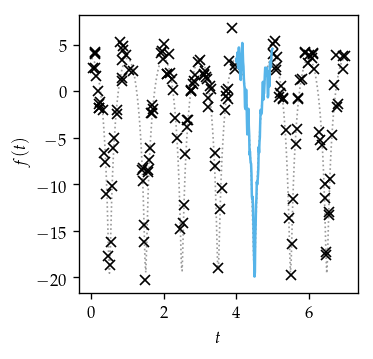

In [54]:
plt.gcf()[:set_size_inches](3, 3)
tt = range(0, stop=24*7, length=24*7*2)
plt.plot(tt./24, diurnal.(tt), ":", label="diurnal cycle", linewidth=1, color="#999999")
plt.plot(t_obs./24, temp_obs, "x", color="black")
plt.plot(t_pred./24, true_pred, color=cbbPalette[2])
plt.xlabel(L"t")
plt.ylabel(L"f(t)")
plt.savefig("../figures/periodic/periodic_sim.pdf", bbox_inches="tight")
plt.savefig("../figures/periodic/periodic_sim.png", bbox_inches="tight")
;

In [6]:
k_periodic = Periodic(0.0, 0.0, log(24.0))
k_noise = Mat32Iso(log(0.5), log(1.5))
k_fit = k_noise + fix(k_periodic, :lp)
gp_periodic = GPE(Matrix(t_obs'), temp_obs, MeanConst(0.0), k_fit, log(0.1))
optimize!(gp_periodic)
pred_periodic = predict_f(gp_periodic, Matrix(t_pred'); full_cov=false)
;

In [15]:
k_noise = Mat32Iso(log(0.5), log(1.5))
mper_under = GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/1)) + 
             GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/2)) +
             MeanConst(0.0)
gp_under = GPE(Matrix(t_obs'), temp_obs, mper_under, k_noise, log(0.1))
optimize!(gp_under)
pred_under = predict_f(gp_under, Matrix(t_pred'); full_cov=false)
;

In [20]:
k_noise = Mat32Iso(log(0.5), log(1.5))
m_periodic = GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/1)) + 
             GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/2)) +
             GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/3)) +
             GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/4)) +
             MeanConst(0.0)
gp_meanper = GPE(Matrix(t_obs'), temp_obs, m_periodic, k_noise, log(0.1))
optimize!(gp_meanper)
pred_meanper = predict_f(gp_meanper, Matrix(t_pred'); full_cov=false)
;

In [21]:
k_noise = Mat32Iso(log(0.5), log(1.5))
mper_over = GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/1)) + 
            GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/2)) +
            GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/3)) +
            GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/4)) +
            GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/5)) +
            GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/6)) +
            MeanConst(0.0)
gp_over = GPE(Matrix(t_obs'), temp_obs, mper_over, k_noise, log(0.1))
optimize!(gp_over)
pred_over = predict_f(gp_over, Matrix(t_pred'); full_cov=false)
;

DomainError(Inf, "cos(x) is only defined for finite x.")


In [22]:
k_periodic = Periodic(0.0, 0.0, log(24.0))
k_noise = Mat32Iso(log(0.5), log(1.5))
k_fit = k_noise + fix(k_periodic, :lp)
m_both = GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/1)) + 
         GaussianProcesses.MeanPeriodic(0.0, 0.0, log(24.0/2)) +
         MeanConst(0.0)
gp_both = GPE(Matrix(t_obs'), temp_obs, m_both, k_fit, log(0.1))
optimize!(gp_both)
pred_both = predict_f(gp_both, Matrix(t_pred'); full_cov=false)
;

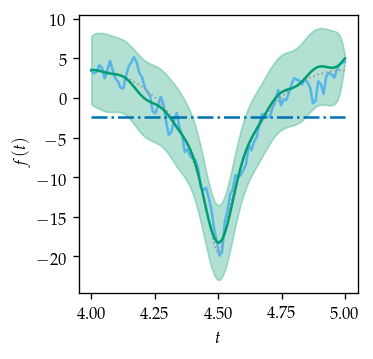

In [53]:
plt.plot(t_pred./24, true_pred, color=cbbPalette[2], label="true process")
tt = range(24*4, stop=24*5, length=24*7*2)
plt.plot(tt./24, diurnal.(tt), ":", label="diurnal cycle", linewidth=1, color="#999999")
let
    y, yerr = pred_periodic
    m = gp_periodic.mean
    meanpred = mean.(Ref(m), ([t] for t in t_pred))
    plt.plot(t_pred./24, y, color=cbbPalette[3])
    plt.plot(t_pred./24, meanpred, "-.", label="fitted mean function", color=cbbPalette[5])
    plt.fill_between(t_pred./24, y .-2 .* yerr, y.+ 2 .* yerr, color=cbbPalette[3], alpha=0.3, label=L"$\mathcal{GP}$ prediction")
end
plt.xlabel(L"t")
plt.ylabel(L"f(t)")

plt.gcf()[:set_size_inches](3, 3)
plt.savefig("../figures/periodic/periodic_results_kper.pdf", bbox_inches="tight")
plt.savefig("../figures/periodic/periodic_results_kper.png", bbox_inches="tight")
;

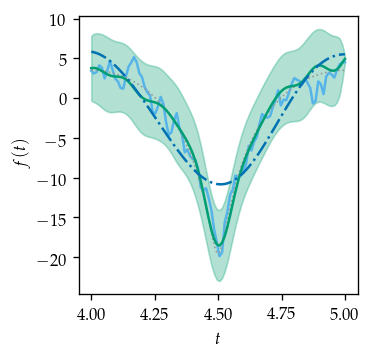

In [48]:
plt.plot(t_pred./24, true_pred, color=cbbPalette[2], label="true process")
tt = range(24*4, stop=24*5, length=24*7*2)
plt.plot(tt./24, diurnal.(tt), ":", label="diurnal cycle", linewidth=1, color="#999999")
let
    y, yerr = pred_both
    m = gp_both.mean
    meanpred = mean.(Ref(m), ([t] for t in t_pred))
    plt.plot(t_pred./24, y, color=cbbPalette[3])
    plt.plot(t_pred./24, meanpred, "-.", label="fitted mean function", color=cbbPalette[5])
    plt.fill_between(t_pred./24, y .-2 .* yerr, y.+ 2 .* yerr, color=cbbPalette[3], alpha=0.3, label=L"$\mathcal{GP}$ prediction")
end
plt.xlabel(L"t")
plt.ylabel(L"f(t)")

plt.gcf()[:set_size_inches](3, 3)
plt.savefig("../figures/periodic/periodic_results_both.pdf", bbox_inches="tight")
plt.savefig("../figures/periodic/periodic_results_both.png", bbox_inches="tight")
;

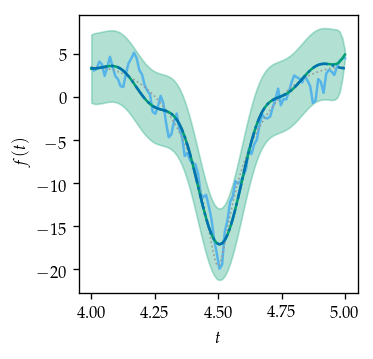

In [49]:
plt.plot(t_pred./24, true_pred, color=cbbPalette[2], label="true process")
tt = range(24*4, stop=24*5, length=24*7*2)
plt.plot(tt./24, diurnal.(tt), ":", label="diurnal cycle", linewidth=1, color="#999999")
let
    y, yerr = pred_meanper
    m = gp_meanper.mean
    meanpred = mean.(Ref(m), ([t] for t in t_pred))
    plt.plot(t_pred./24, y, color=cbbPalette[3])
    plt.plot(t_pred./24, meanpred, "-.", label="fitted mean function", color=cbbPalette[5])
    plt.fill_between(t_pred./24, y .-2 .* yerr, y.+ 2 .* yerr, color=cbbPalette[3], alpha=0.3, label=L"$\mathcal{GP}$ prediction")
end
plt.xlabel(L"t")
plt.ylabel(L"f(t)")

plt.gcf()[:set_size_inches](3, 3)
plt.savefig("../figures/periodic/periodic_results_meanper.pdf", bbox_inches="tight")
plt.savefig("../figures/periodic/periodic_results_meanper.png", bbox_inches="tight")
;

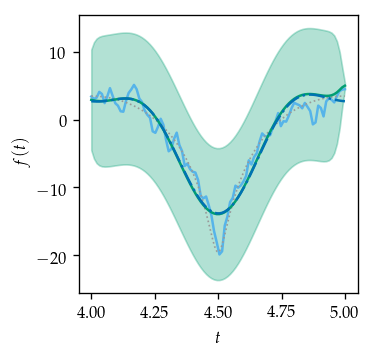

In [50]:
plt.plot(t_pred./24, true_pred, color=cbbPalette[2], label="true process")
tt = range(24*4, stop=24*5, length=24*7*2)
plt.plot(tt./24, diurnal.(tt), ":", label="diurnal cycle", linewidth=1, color="#999999")
let
    y, yerr = pred_under
    m = gp_under.mean
    meanpred = mean.(Ref(m), ([t] for t in t_pred))
    plt.plot(t_pred./24, y, color=cbbPalette[3])
    plt.plot(t_pred./24, meanpred, "-.", label="fitted mean function", color=cbbPalette[5])
    plt.fill_between(t_pred./24, y .-2 .* yerr, y.+ 2 .* yerr, color=cbbPalette[3], alpha=0.3, label=L"$\mathcal{GP}$ prediction")
end
plt.xlabel(L"t")
plt.ylabel(L"f(t)")

plt.gcf()[:set_size_inches](3, 3)

plt.savefig("../figures/periodic/periodic_results_under.pdf", bbox_inches="tight")
plt.savefig("../figures/periodic/periodic_results_under.png", bbox_inches="tight")
;

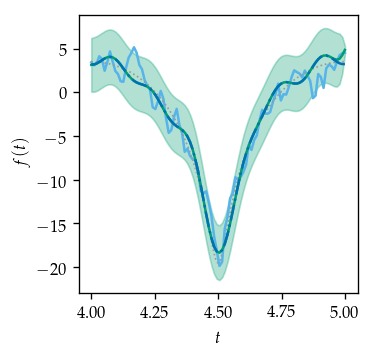

In [51]:
plt.plot(t_pred./24, true_pred, color=cbbPalette[2], label="true process")
tt = range(24*4, stop=24*5, length=24*7*2)
plt.plot(tt./24, diurnal.(tt), ":", label="diurnal cycle", linewidth=1, color="#999999")
let
    y, yerr = pred_over
    m = gp_over.mean
    meanpred = mean.(Ref(m), ([t] for t in t_pred))
    plt.plot(t_pred./24, y, color=cbbPalette[3])
    plt.plot(t_pred./24, meanpred, "-.", label="fitted mean function", color=cbbPalette[5])
    plt.fill_between(t_pred./24, y .-2 .* yerr, y.+ 2 .* yerr, color=cbbPalette[3], alpha=0.3, label=L"$\mathcal{GP}$ prediction")
end
plt.xlabel(L"t")
plt.ylabel(L"f(t)")

plt.gcf()[:set_size_inches](3, 3)

plt.savefig("../figures/periodic/periodic_results_over.pdf", bbox_inches="tight")
plt.savefig("../figures/periodic/periodic_results_over.png", bbox_inches="tight")
;